In [362]:
library(caret)
library(glmnet)

In [363]:
coin_data <- read.csv("../imp_coin.csv")[-c(1,2,4,5,6,8)]
coin_data_test <-read.csv("../imp_coin_test.csv")[-c(1,2,4,5,6,8)]

In [370]:
coin_data <- tail(read.csv("../imp_coin.csv")[c(3,7,9,13,15,19,21,25,27,31,33,37,39,43)], 2000)
coin_data_test <-read.csv("../imp_coin_test.csv")[c(3,9,15,21,27,33,39)]

In [371]:
head(coin_data)

,btc_price,btc_vol,bch_price,bch_vol,eos_price,eos_vol,eth_price,eth_vol,ltc_price,ltc_vol,usdt_price,usdt_vol,xrp_price,xrp_vol
1091,94.0,101550,0,0,0,0,0,0,0,0,0,0,0,0
1092,98.3,34460,0,0,0,0,0,0,0,0,0,0,0,0
1093,94.4,12340,0,0,0,0,0,0,0,0,0,0,0,0
1094,98.9,34510,0,0,0,0,0,0,0,0,0,0,0,0
1095,97.1,16530,0,0,0,0,0,0,0,0,0,0,0,0
1096,98.5,17270,0,0,0,0,0,0,0,0,0,0,0,0


Training sample

In [372]:
set.seed(1)
training.samples <- createDataPartition(coin_data$btc_price, p = 0.7, list = FALSE)
train.data  <- coin_data[training.samples, ]
test.data <- coin_data[-training.samples, ]

x <- model.matrix(btc_price~., train.data)[,-1]
y <- as.double(train.data$btc_price)
x.test <- model.matrix(btc_price ~., test.data)[,-1]

k-fold Cross Validation, nb = 10

In [373]:
lambdas_to_try <- 10^seq(-3, 10, length.out = 100)
set.seed(1) 
cv.lasso <- cv.glmnet(x, y, alpha = 1, type.measure='mse', lambda = lambdas_to_try, nfolds = 10)

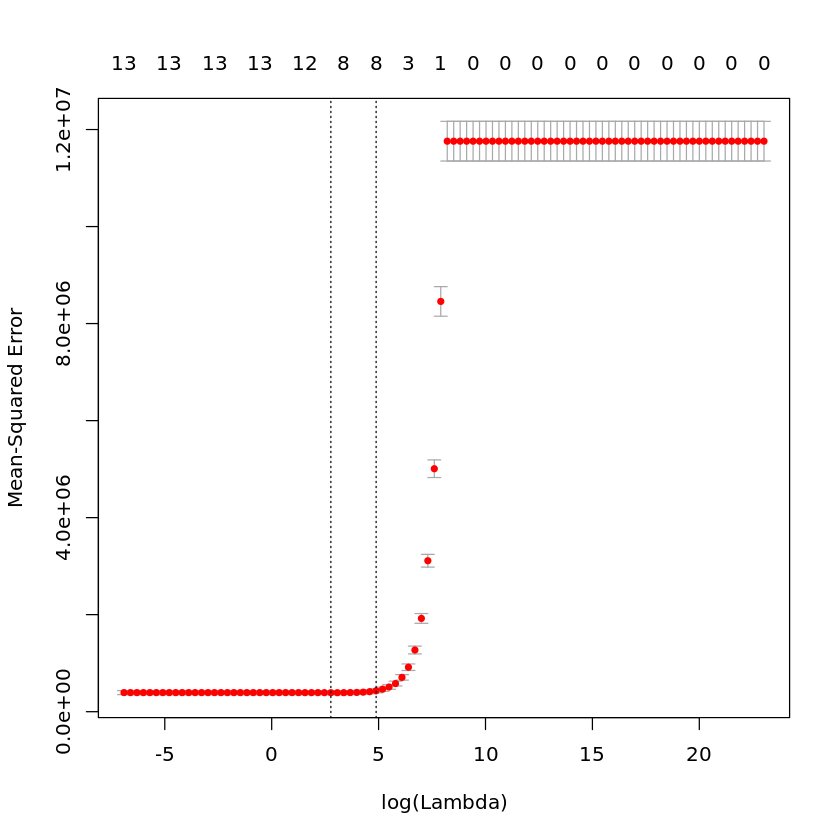

In [374]:
plot(cv.lasso)

In [375]:
cv.lasso$lambda.min

[1] 15.92283

In [376]:
cv.lasso$lambda.1se

[1] 132.1941

In [377]:
model_10_nfolds <- glmnet(x, y, alpha = 1, family = "gaussian", lambda = cv.lasso$lambda.min)
pred_10 = predict(model_10_nfolds, newx = x.test)

# k-fold Cross Validation, nb = 5

In [378]:
lambdas_to_try <- 10^seq(-3, 10, length.out = 100)
set.seed(1)
cv.lasso <- cv.glmnet(x, y, alpha = 1, type.measure='mse', lambda = lambdas_to_try, nfolds = 5)

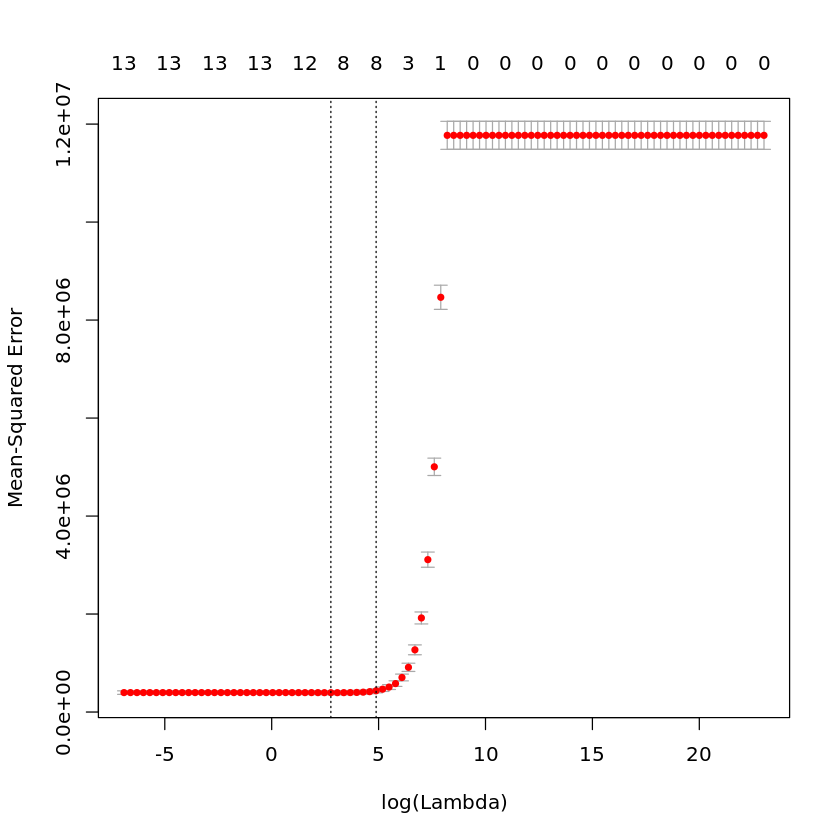

In [379]:
plot(cv.lasso)

In [380]:
cv.lasso$lambda.min

[1] 15.92283

In [381]:
cv.lasso$lambda.1se

[1] 132.1941

lambda min of k-fold Cross Validation nb = 5 > k-fold Cross Validation nb = 10

In [382]:
# Fit the final model on the training data
model_5_nfolds <- glmnet(x, y, alpha = 1, family = "gaussian", lambda = cv.lasso$lambda.min)
pred_5 = predict(model_5_nfolds, newx = x.test)

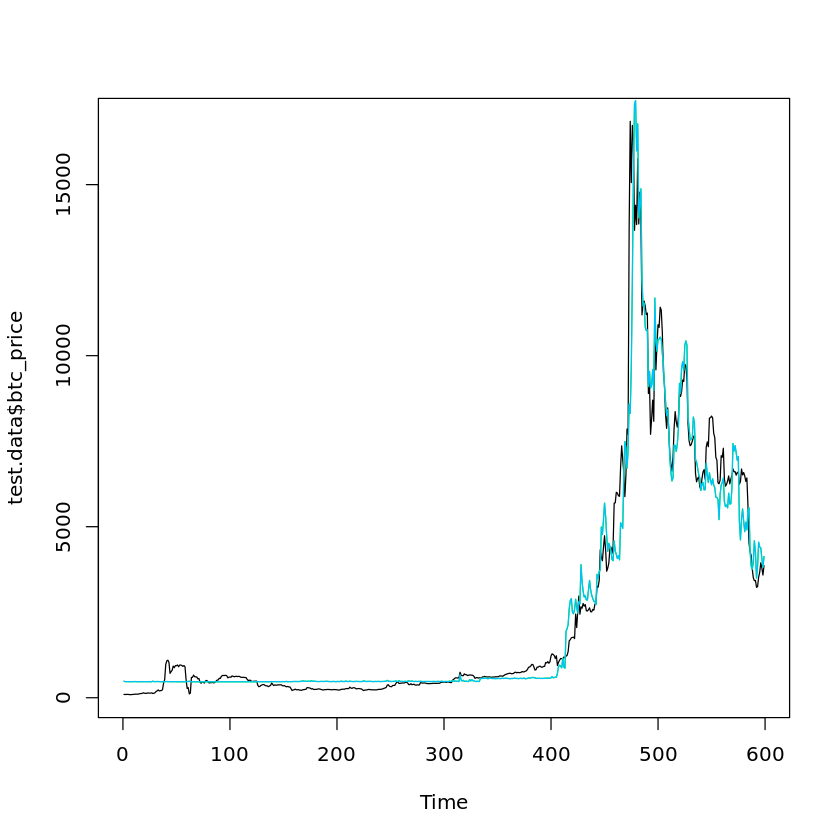

In [383]:
plot.ts(test.data$btc_price)
lines(pred_5, col="green")
lines(pred_10, col="deepskyblue")

In [384]:
mean((test.data$btc_price - pred_5)^2)

[1] 540087.4

In [385]:
mean((test.data$btc_price - pred_10)^2)

[1] 540087.4

In [358]:
test_last_20 <- model.matrix(btc_price ~., coin_data_test)[,-1]

In [359]:
mean((coin_data_test$btc_price - predict(model_10_nfolds, newx = test_last_20))^2)

[1] 6985.284

In [360]:
mean((coin_data_test$btc_price - predict(model_5_nfolds, newx = test_last_20))^2)

[1] 10315.52

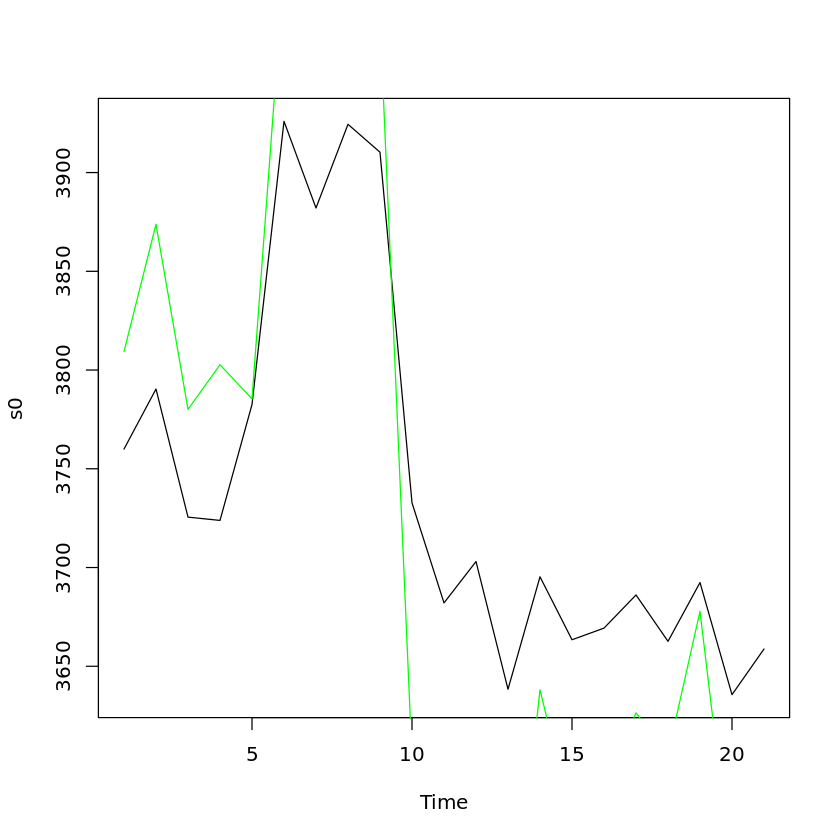

In [361]:
pred_last_20 <- predict(model_10_nfolds, newx = test_last_20)
plot.ts(pred_last_20)
lines(coin_data_test$btc_price, col="green")

                            model_10_nfolds|  model_5_nfolds
new 20, all data  , 1   , mse    | 117535  |  118608
new 20, tail 1000 , 1   , mse    |  88659  |   88659
new 20, tail 800  , 1   , mse    |  83383  |   79808

-------------------------------------------------------------

test  , tail 800  , 0.8 , mse    |  712609 |  712609
new 20, tail 800  , 0.8 , mse    |   75888 |   75888
test  , tail 1000 , 0.8 , mse    |  364316 |  364316
new 20, tail 1000 , 0.8 , mse    |   67211 |   67211
test  , all data  , 0.8 , mse    |  364316 |  177342
new 20, all data  , 0.8 , mse    |   75888 |   75888

-------------------------------------------------------------

test  , tail 800  , 0.7 , mse    |  568059 |  555982
new 20, tail 800  , 0.7 , mse    |   74645 |   76289
test  , tail 1000 , 0.7 , mse    |  490629 |  471405
new 20, tail 1000 , 0.7 , mse    |  100769 |   92042
test  , all data  , 0.7 , mse    |  178678 |  179555
new 20, all data  , 0.7 , mse    |  109650 |  143420


Model with lowest MSE on new set is : tail: 1000 , 80% trained (same value on 10 and 5 nfold) mse = 67211

on validation data : all data set, 70 % training ( 10 kfold) mse = 178678
on validation data : all data set, 80 % training ( 5 kfold) mse = 177342